NOTE: In this file, we create classes by binning revenues for our classification models. The dataset used is located at `../clean-datasets/primary-with-revenue.csv`.

# Preprocessing

## Preprocessing classes

### `DataPreprocessor` 
Composes loading, encoding, scaling, and implements balancing.

In [1]:
import subprocess
import sys
def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '--quiet'])
install('imblearn')

from imblearn.over_sampling import SMOTE
from collections import Counter

class DataPreprocessor:
    """Order: load -> encode -> feature augment -> balance -> scale."""
    def __init__(self):
        self.encoder = None
        self.scaler = None
    
    def load_data(self):
        """Load the dataset, split into X and y, then split into train-test sets."""
        X_train, X_test, y_train, y_test = DataLoader.load_datasets()
        self.encoder = DataEncoder(X_train, X_test)
        print('Loaded data!')
        return X_train, X_test, y_train, y_test
    
    def encode_data(self, encodings):
        """Encode categorical features in datasets."""
        if self.encoder is None:
            raise ValueError('Data not loaded. Use `load_data` first.')
        self.encoder.encode(encodings)
        X_train_encoded, X_test_encoded = self.encoder.read()
        print('Encoded data!')
        return X_train_encoded, X_test_encoded

    def scale_data(self, scalings):
        """Scale features in datasets."""
        if self.scaler is None:
            raise ValueError('Data not loaded, encoded, and balanced. Use `load_data` first, then use `encode_data`, and finally use `balance_data`.')
        self.scaler.scale(scalings)
        X_train_scaled, X_test_scaled = self.scaler.read()
        print('Scaled data!')
        return X_train_scaled, X_test_scaled
        
    def balance_data(self, X_train, y_train, X_test, ratio=1/3):
        """Balance the target classes via oversampling."""
        if not (0 < ratio <= 1):
            raise ValueError('The ratio must be a float between 0 and 1.')
        
        class_counts = y_train.value_counts().to_dict()
        print('Class distribution before SMOTE:')
        for class_label, count in class_counts.items():
            print(f'Class {class_label}: {count}')
        
        max_key = max(class_counts, key=class_counts.get)
        max_value = class_counts[max_key]

        sampling_strategy = {}
        target_threshold = int(max_value * ratio)
        for class_label, count in class_counts.items():
            if count < target_threshold:
                sampling_strategy[class_label] = target_threshold

        sampling_strategy[max_key] = max_value
        sampling_strategy = {k: int(v) for k, v in sampling_strategy.items()}

        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        new_class_counts = pd.Series(y_train_balanced).value_counts().to_dict()
        print('\nClass distribution after SMOTE:')
        for class_label, count in new_class_counts.items():
            print(f'Class {class_label}: {count}')
        
        self.scaler = DataScaler(X_train_balanced, X_test)
        print('Balanced data!')
        return X_train_balanced, y_train_balanced 

### `DataLoader`
Implements data loading, which includes splitting base dataset into feature and target sets, and that into training and test sets.

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

class DataLoader:
    @staticmethod
    def load_datasets():
        pd.set_option('display.max_columns', None)
        
        primary_revenue = pd.read_csv('../clean-datasets/primary-with-valuation.csv')
        primary_revenue['year_founded'] = primary_revenue['year_founded'].astype(int) # year_founded float -> int
        
        # Make revenue bins
        percentile_labels = [0, 1, 2] # low(0), medium(1), high(2)
        primary_revenue['valuation_bins'] = pd.qcut(primary_revenue['valuation_millions'], q=len(percentile_labels), labels=percentile_labels)
        
        X = primary_revenue.drop(['valuation_millions','valuation_bins','valuation_date'], axis=1)
        y = primary_revenue['valuation_bins']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test

### `DataEncoder`
Implements data encoding, including dropping, one-hot, frequency, and label encoding.

In [3]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import pandas as pd

class DataEncoder:
    def __init__(self, X_train, X_test):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        
    def encode(self, encodings):
        self.encodings = encodings
        for method in ['drop', 'ohe', 'freq', 'label']:
            if method in encodings:
                getattr(self, method)(encodings[method])

    def read(self):
        return self.X_train, self.X_test

    def drop(self, features):
        """Drop specified features."""
        for df in [self.X_train, self.X_test]:
            df.drop(columns=features, inplace=True)

    def ohe(self, features):
        """One-hot encode specified features."""
        self.X_train = pd.get_dummies(self.X_train, columns=features, drop_first=False, prefix=features)
        self.X_test = pd.get_dummies(self.X_test, columns=features, drop_first=False, prefix=features)

    def freq(self, features):
        """Frequency encode specified features."""
        for feature in features:
            freq = self.X_train[feature].value_counts(normalize=True)
            freqs = freq.to_dict()
            mean_freq = freq.mean()
            for df in [self.X_train, self.X_test]:
                df[feature] = df[feature].map(freqs).fillna(mean_freq)
                
    def label(self, features):
        """Label encode specified features."""
        for feature in features:
            combined_df = pd.concat([self.X_train, self.X_test], axis=0)
            le = LabelEncoder().fit(combined_df[feature])
            
            for df in [self.X_train, self.X_test]:
                df[feature] = le.transform(df[feature])

### `DataScaler`
Implements data scaling, including logarithmic scaling, standard scaling, and min-max scaling.

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class DataScaler:
    def __init__(self, X_train, X_test):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.methods = ['log_scale', 'standard_scale', 'robust_scale', 'yeo_johnson_scale', 'quantile_scale', 'minmax_scale']
        self.columns = self.X_train.columns
        
    def scale(self, scalings):
        self.scalings = scalings
        for method in self.methods:
            if method in scalings:
                getattr(self, method)(scalings[method])
                
    def read(self):
        return self.X_train, self.X_test
        
    def log_scale(self, features):
        """Log scale specified features. Use when data is right skewed."""
        combined_df = pd.concat([self.X_train, self.X_test], axis=0)
        for feature in features:
            left_bound = combined_df[feature].min()
            shift = 0
            if left_bound < 0:
                shift = abs(left_bound)
            for df in [self.X_train, self.X_test]:
                df[feature] = np.log1p(df[feature] + shift)
    
    def scikit_scale(self, features, scaler):
        """Scikitlearn scaler base function."""
        for feature in features:
            s = scaler.fit(self.X_train[[feature]])
            for df in [self.X_train, self.X_test]:
                df[feature] = s.transform(df[[feature]])
    
    def standard_scale(self, features):
        """Standard scale specified features. Use when data is near normal."""
        self.scikit_scale(features, StandardScaler())
                
    def minmax_scale(self, features):
        """Min-max scale specified features. Use when data is near uniform."""
        self.scikit_scale(features, MinMaxScaler())
                
    def robust_scale(self, features):
        """Robust scale specified features. Use when outliers present."""
        self.scikit_scale(features, RobustScaler())
                
    def yeo_johnson_scale(self, features):
        """Yeo-Johnson scale specified features. Use when data is skewed."""
        self.scikit_scale(features, PowerTransformer(method='yeo-johnson'))
                
    def quantile_scale(self, features):
        """Quantile scale specified features. Maps data to a normal distribution."""
        self.scikit_scale(features, QuantileTransformer(output_distribution='normal'))

### `ScalerPreview`
Implements scaling preview to help with deciding how to scale different features.

In [5]:
import ipywidgets as widgets
from IPython.display import display

class ScalerPreview:
    def __init__(self, X_train, X_test):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.scaler = DataScaler(self.X_train, self.X_test)
    
    def pick(self):
        feature = widgets.Dropdown(options=self.scaler.columns, description='Feature:')
        method = widgets.Dropdown(options=self.scaler.methods, description='Method:')
        
        controls = widgets.VBox([feature, method])
        display(controls)
        
        output = widgets.interactive_output(self.preview_scaling, {'feature': feature, 'method': method})
        display(output)

    def preview_scaling(self, feature, method):
        self.scaler = DataScaler(self.X_train, self.X_test)
        colors = sns.color_palette('Paired')
        swapped_colors = [colors[1], colors[0]]
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        labels = ['X_train', 'X_test']

        # Un-scaled
        for i, df in enumerate([self.X_test, self.X_train]):
            if feature in df.columns:
                sns.kdeplot(df[feature], label=labels[i], linestyle='--', 
                            color=swapped_colors[i], fill=True, alpha=0.2, cut=0, ax=axes[0])
        axes[0].set_title('Un-scaled data')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Density')

        # Scaled
        self.scaler.scale({method: [feature]})
        X_train_scaled, X_test_scaled = self.scaler.read()
        
        for i, df in enumerate([X_test_scaled, X_train_scaled]):
            if feature in df.columns:
                sns.kdeplot(df[feature], label=labels[i], color=swapped_colors[i], 
                            fill=True, alpha=0.5, cut=0, ax=axes[1])
        axes[1].set_title(method)
        axes[1].set_xlabel(feature)
        axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        axes[1].axvline(0, color='black', linestyle='--', linewidth=1)

        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.show()

## Preprocessing main

## Loading

In [127]:
preprocessor = DataPreprocessor()

X_train, X_test, y_train, y_test = preprocessor.load_data()

Loaded data!


## Encoding

In [108]:
X_train.select_dtypes(exclude=['number']).nunique()

name                 631
tagline              629
summary              631
description          631
website              631
city                 167
region                55
country               40
postal_code          404
concepts             617
keywords             629
last_funding_type     89
last_funding_date    450
sentiment            631
articles             631
dtype: int64

### Everything but dates

The `encodings` dictionary tells the preprocessor which features to encode using which method. 

In [128]:
encodings = {
    'ohe': [],
    'drop': ['name','tagline','summary','description','website','concepts','sentiment','articles','funding_total_millions','funding_count','investor_count'],
    'freq': ['city','postal_code'],
    'label': ['region','country','last_funding_type']
}

X_train_encoded, X_test_encoded = preprocessor.encode_data(encodings)

Encoded data!


### Dates

In [129]:
for df in [X_train_encoded, X_test_encoded]:
    df['last_funding_date'] = pd.to_datetime(df['last_funding_date'])
    df['last_funding_year'] = df['last_funding_date'].dt.year
    df['last_funding_month'] = df['last_funding_date'].dt.month
    df['last_funding_day'] = df['last_funding_date'].dt.day
    df.drop('last_funding_date', axis=1, inplace=True)

## Feature augmenting (optional)

### Standard augmenting:

In [130]:
X_train_augmented = X_train_encoded.copy()
X_test_augmented = X_test_encoded.copy()

augment = False

if augment:
    for df in [X_train_augmented, X_test_augmented]:
        df['funding_per_investor'] = df['funding_total_millions'] / df['investor_count']
        df['funding_per_round'] = df['funding_total_millions'] / df['funding_count']
        df['last_funding_since_founded'] = df['last_funding_year'] - df['year_founded']

### Augmenting dataset with keywords:

Here, we try to encode keywords, which describe the discipline of each company based on several keywords as a feature that the model can use to predict valuation.

We start by one-hot encoding all the keywords in each list for each company using Scikit-learn's `MultiLabelBinarizer`.\
Then we use Scikit-learn's `TfidfTransformer` to reduce the effects of our sparse one-hot encoded matrix.\
Then, we use `KMeans` to cluster similar points in our one-hot encoded vector space.\
Finally, we display the number of keywords in each bin, and the most common keywords found in each bin, along with a graph for visualization.

In [131]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
import ast

for df in [X_train_augmented, X_test_augmented]:
    df['keywords'] = df['keywords'].apply(lambda x: [keyword.lower() for keyword in ast.literal_eval(x)])
    
    # Apply MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot = mlb.fit_transform(df['keywords'])
    one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
    
    # Apply TF-IDF to the one-hot encoded data
    tfidf = TfidfTransformer()
    one_hot_tfidf = tfidf.fit_transform(one_hot_df)
    
    # KMeans clustering
    num_bins = 9
    kmeans = KMeans(n_clusters=num_bins, random_state=1234, n_init='auto')
    df['keyword_bins'] = kmeans.fit_predict(one_hot_tfidf)
    
print(X_train_augmented[['keywords', 'keyword_bins']].head())


                                              keywords  keyword_bins
432  [your list of company industry categories to c...             1
582  [edtech, fintech, application software, ai as ...             1
442  [fintech, platform as a service (paas), e-comm...             6
675  [software, procurement, saas management, it se...             4
334  [data analytics, business intelligence, saas, ...             7


In [132]:
X_train_augmented['keyword_bins'].value_counts().sort_index()

0     59
1    268
2     45
3     22
4     81
5     24
6     65
7     42
8     35
Name: keyword_bins, dtype: int64

We use `networkx` to create a graph that shows which keyword bins connect to which keywords, and which bins share common keywords.\
It is interesting to see that, using our clustering algorithm, we have created clusters with keywords that are conceptually tangential, ie. Bin 0 has Cybersecurity, Software Development, and Information Technology & Services, while Bin 9 has Electric Vehicles, Renewable Energy, and Energy Storage.

Top 3 most common keywords in each bin:
Bin 0:
	cybersecurity: 39
	software development: 25
	information technology: 21
Bin 1:
	artificial intelligence & machine learning: 53
	financial technology: 20
	data analytics: 19
Bin 2:
	healthcare: 22
	biotechnology: 17
	artificial intelligence & machine learning: 16
Bin 3:
	entertainment: 16
	gaming: 7
	technology: 7
Bin 4:
	financial services: 63
	fintech: 45
	technology: 14
Bin 5:
	digital health: 13
	consumer electronics: 11
	healthtech: 6
Bin 6:
	e-commerce: 63
	retail: 16
	technology: 10
Bin 7:
	saas: 35
	business services: 19
	enterprise software: 17
Bin 8:
	software: 26
	technology: 15
	human resources: 9


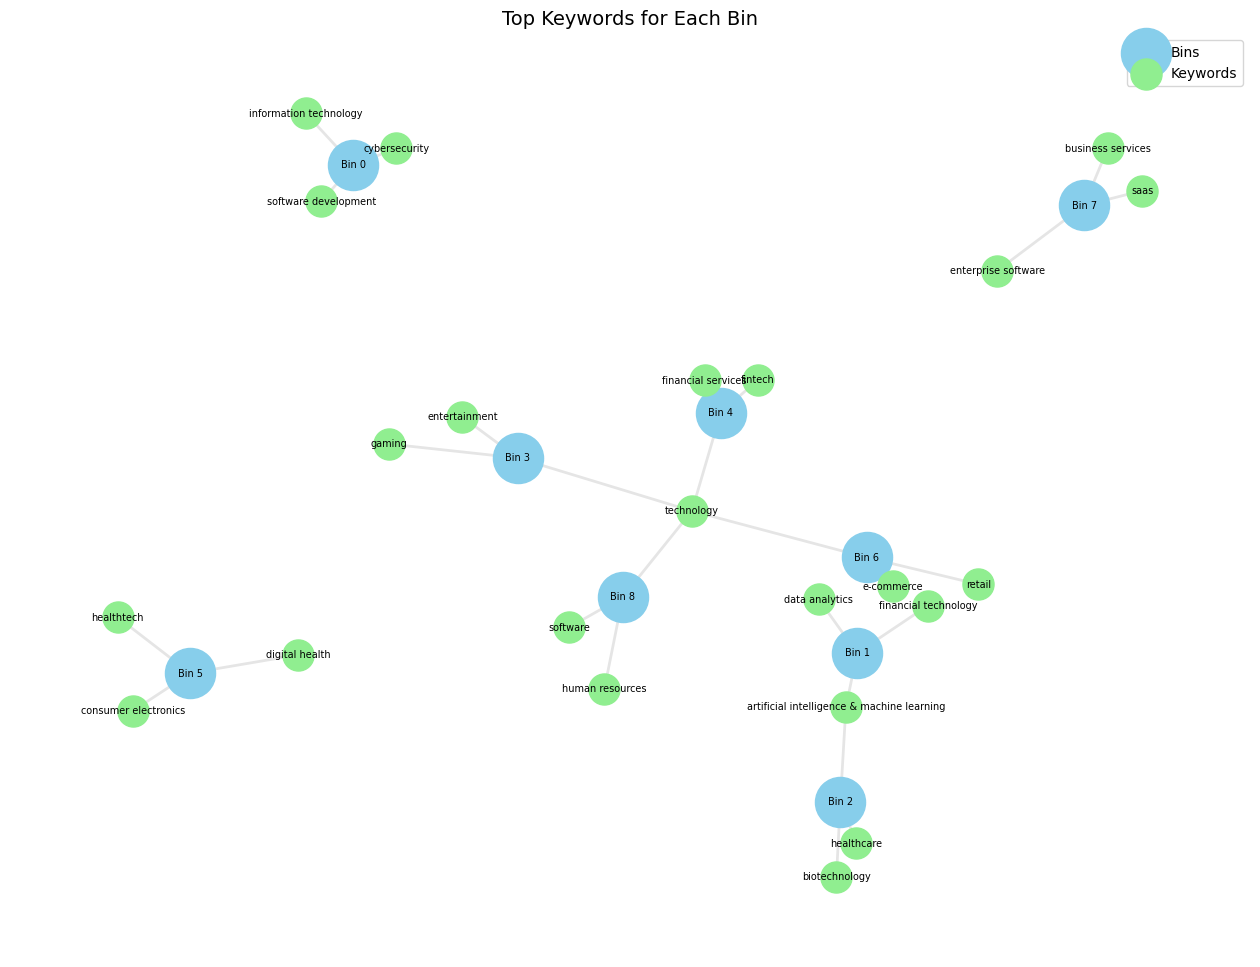

In [133]:
from collections import Counter
import networkx as nx

G = nx.Graph()

print('Top 3 most common keywords in each bin:')
for i in range(0,num_bins):
    binned_keywords = X_train_augmented[X_train_augmented['keyword_bins'] == i]['keywords']

    all_keywords = [keyword for sublist in binned_keywords for keyword in sublist]

    keyword_counts = Counter(all_keywords)
    most_common_keywords = keyword_counts.most_common(3)

    print(f'Bin {i}:')
    for word, count in most_common_keywords:
        print(f'\t{word}: {count}')
        
    G.add_node(f'Bin {i}', type='bin')
    for word, count in most_common_keywords:
        G.add_node(word, type='keyword')
        G.add_edge(f'Bin {i}', word, weight=count)
        
plt.figure(figsize=(16, 12))

pos = nx.spring_layout(G, seed=42, k=0.6)

bin_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'bin']
keyword_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'keyword']

nx.draw_networkx_nodes(G, pos, nodelist=bin_nodes, node_color='skyblue', node_size=1300, label='Bins')
nx.draw_networkx_nodes(G, pos, nodelist=keyword_nodes, node_color='lightgreen', node_size=500, label='Keywords')

nx.draw_networkx_edges(G, pos, width=2, alpha=0.1)

nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')

plt.legend(['Bins', 'Keywords'], loc='upper right')
plt.title('Top Keywords for Each Bin', fontsize=14)
plt.axis('off')
plt.show()


Finally, we one-hot encode the `keyword_bins` feature and drop the `keywords` feature. 

In [134]:
de = DataEncoder(X_train_augmented, X_test_augmented)
de.ohe(['keyword_bins'])
X_train_augmented, X_test_augmented = de.read()
de.drop(['keywords'])

In [135]:
X_train_augmented.head(2)

,year_founded,city,region,country,postal_code,mosaic_change,last_funding_millions,last_funding_type,last_funding_year,last_funding_month,last_funding_day,keyword_bins_0,keyword_bins_1,keyword_bins_2,keyword_bins_3,keyword_bins_4,keyword_bins_5,keyword_bins_6,keyword_bins_7,keyword_bins_8
432,2018,0.021849,33,42,0.001623,-38.0,50.0,57,2022,1,27,0,1,0,0,0,0,0,0,0
582,2017,0.006723,64,18,0.001623,-38.0,13.0,47,2023,9,22,0,1,0,0,0,0,0,0,0


## Balancing

The classes are balanced using SMOTE oversampling such that for each minority class:

$$\text{minority class samples} \geq \text{ratio} \cdot \text{majority class samples}$$

In [136]:
X_train_balanced, y_train_balanced = preprocessor.balance_data(X_train_augmented, y_train, X_test_augmented, ratio=1/3)

Class distribution before SMOTE:
Class 1: 239
Class 0: 218
Class 2: 184

Class distribution after SMOTE:
Class 1: 239
Class 0: 218
Class 2: 184
Balanced data!


## Scaling

The `ScalerPreview` class lets us graphically preview how a feature will change when scaled by a certain method.

In [71]:
preview = ScalerPreview(X_train_balanced, X_test_augmented)
preview.pick()

Output()

The `scalings` dictionary tells the preprocessor which features to scale using which method. 

In [137]:
scalings = {
    'log_scale': ['last_funding_millions'],
    'standard_scale': ['year_founded'], 
    'robust_scale': ['mosaic_change'],
    'yeo_johnson_scale': ['region','postal_code','last_funding_type'],
    'quantile_scale': [],
    'minmax_scale': ['city','country','last_funding_year','last_funding_month','last_funding_day']
}

X_train_scaled, X_test_scaled = preprocessor.scale_data(scalings)

Scaled data!


## Final datasets

In [138]:
X_train = X_train_scaled
y_train = y_train_balanced
X_test = X_test_scaled
y_test = y_test

# Modeling

For reduced code repetition and ease of use I created a base model class that each individual model (decision tree/random forest, logistic regression, KNN, SVM) inherits functionality from. Each individual model also has its own functionality. 

## Base Model

The base model implements functionality that is common to all types of machine learning models. It has one abstract method called 'define_model' that is implemented by its subclasses.  

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, roc_auc_score
from IPython.display import display, HTML
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np


class BaseModelTrainer(ABC):
    def __init__(self, X_train, y_train, X_test, y_test, params=dict()):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.name = None
        self.model = None
        self.predictions = None
        self.probabilities = None
        self.params = params 

    @abstractmethod
    def define_model(self):
        """Implemented in subclasses."""
        pass

    def train(self):
        """Subclass defines model then Scikitlearn fits it."""
        self.define_model()
        self.model.fit(self.X_train, self.y_train.values.ravel())

    def predict(self):
        """Scikitlearn predicts test data."""
        self.predictions = self.model.predict(self.X_test)
        if hasattr(self.model, 'predict_proba'):
            self.probabilities = self.model.predict_proba(self.X_test)
        return self.predictions

    def accuracy_score(self):
        return accuracy_score(self.y_test, self.predictions)
    
    def precision_score(self):
        return precision_score(self.y_test, self.predictions, average='macro')

    def recall_score(self):
        return recall_score(self.y_test, self.predictions, average='macro')

    def f1_score(self):
        return f1_score(self.y_test, self.predictions, average='macro')

    def confusion_matrix(self):
        return confusion_matrix(self.y_test, self.predictions)

    def plot_model_performance(self):
        """Plots confusion matrix and ROC curve on the same figure."""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        self.plot_confusion_matrix(axes, title=f'{self.name} Confusion Matrix')
        self.plot_roc_curve(axes, title=f'{self.name} ROC Curve')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def plot_confusion_matrix(self, axes, title='Confusion Matrix'):
        """Plots confusion matrix."""
        cm = self.confusion_matrix()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                    xticklabels=np.unique(self.y_test),
                    yticklabels=np.unique(self.y_test))
        axes[0].set_title(title)
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('True Label')
        axes[0].xaxis.tick_top()
        axes[0].xaxis.set_label_position('top')
        axes[0].set_aspect('equal')

    def plot_roc_curve(self, axes, title='ROC Curve'):
        """Plots multiclass ROC curve using one-vs-rest approach."""
        if self.probabilities is None:
            raise ValueError('Model does not support probability prediction.')

        # One-vs-rest
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = self.probabilities.shape[1]

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test == i, self.probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i in range(n_classes):
            axes[1].plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1].set_title(title)
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='lower right')
        axes[1].set_aspect('equal')

    def print_summary(self):
        """Prints basic summary info including accuracy, precision, recall, f1 score, confusion matrix, and ROC curve."""
        display(HTML(f"<h1 style='font-size:24px; font-weight:bold;'>{self.name} Performance</h1>"))

        summary_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            'Score': [self.accuracy_score(), self.precision_score(), self.recall_score(), self.f1_score()]
        })
        summary_df['Score'] = summary_df['Score'].map('{:.3f}'.format)
        display(summary_df.style.hide(axis='index'))

        self.plot_model_performance()
        display(HTML(f"<h1 style='font-size:24px; font-weight:bold;'>{self.name} Parameters</h1>"))

    def display_predictions_dataframe(self, display_type='both', length=5):
        """Prints correct and/or incorrect samples based on their true value vs their predicted value."""
        results_df = self.X_test.copy()
        results_df['True Label'] = self.y_test.values
        results_df['Predicted Label'] = self.predictions

        if display_type == 'correct':
            results_df = results_df[results_df['True Label'] == results_df['Predicted Label']]
            print(f'Correct predictions: {len(results_df)}')
        elif display_type == 'incorrect':
            results_df = results_df[results_df['True Label'] != results_df['Predicted Label']]
            print(f'Incorrect predictions: {len(results_df)}')
        else:
            print(f'Total predictions: {len(results_df)}')

        results_df = results_df.head(length)

        def highlight_correct(row):
            color = 'background-color: lightgreen' if row['True Label'] == row['Predicted Label'] else 'background-color: lightcoral'
            return [color] * len(row)

        styled_df = results_df.style.apply(highlight_correct, axis=1)
        display(styled_df)

        print('\nSummary of predictions per class:')
        summary = results_df.groupby(['True Label', 'Predicted Label']).size().unstack(fill_value=0)
        display(summary)
        
    def tune_hyperparameters(self, param_grid, cv=5):
        """Uses GridSearchCV to test different hyperparameters.

        Returns the best parameters.
        """
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, scoring='f1_macro')
        grid_search.fit(self.X_train, self.y_train.values.ravel())
        self.model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print('Best parameters found:', best_params)
        return best_params


## Decision Tree

### Model

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

class DecisionTreeTrainer(BaseModelTrainer):
    def define_model(self):
        """Defines model as decision tree."""
        self.name = 'Decision Tree'
        self.model = DecisionTreeClassifier(**self.params, random_state=1234)
        
    def get_tree_depth(self):
        return self.model.get_depth()
        
    def plot_decision_tree(self, feature_names):
        """Plots decision tree using plot_tree."""
        depth = self.get_tree_depth()
        if depth > 5:
            print(f'Tree with depth of {depth} too big to display.')
            return
        class_names = [f'Class {i}' for i in range(0,len(np.unique(self.y_test)))]
        plt.figure(figsize=(20, 10))
        plot_tree(self.model, feature_names=feature_names, class_names=class_names, filled=True)
        plt.show()    
    
    def print_summary(self):
        super().print_summary()
        print(f'Depth: {self.get_tree_depth()}')
        self.plot_decision_tree(self.X_train.columns)

Metric,Score
Accuracy,0.509
Precision,0.558
Recall,0.513
F1 Score,0.522


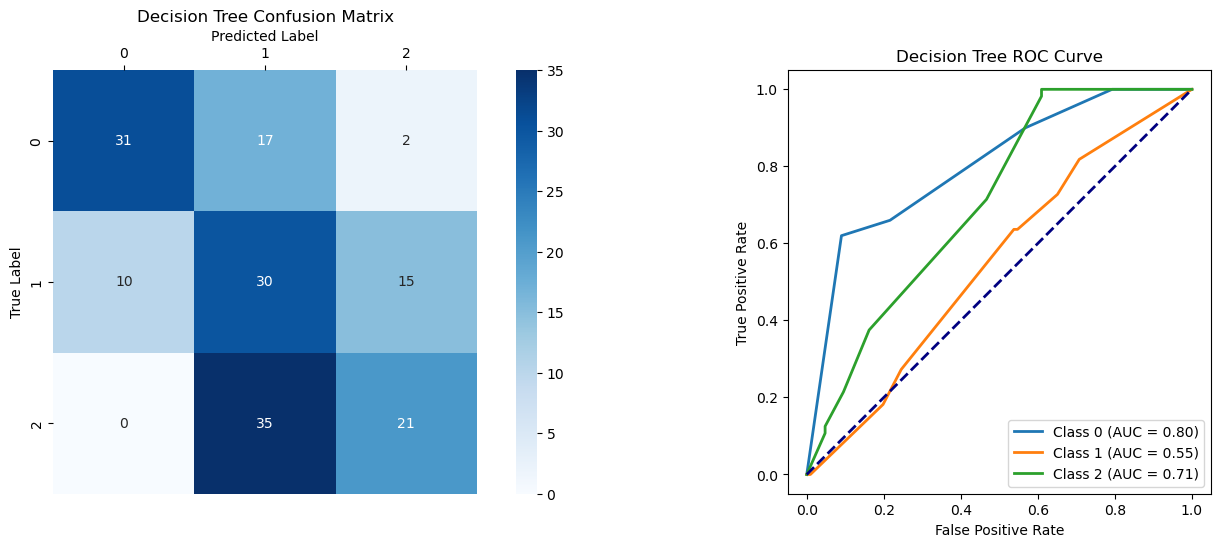

Depth: 3


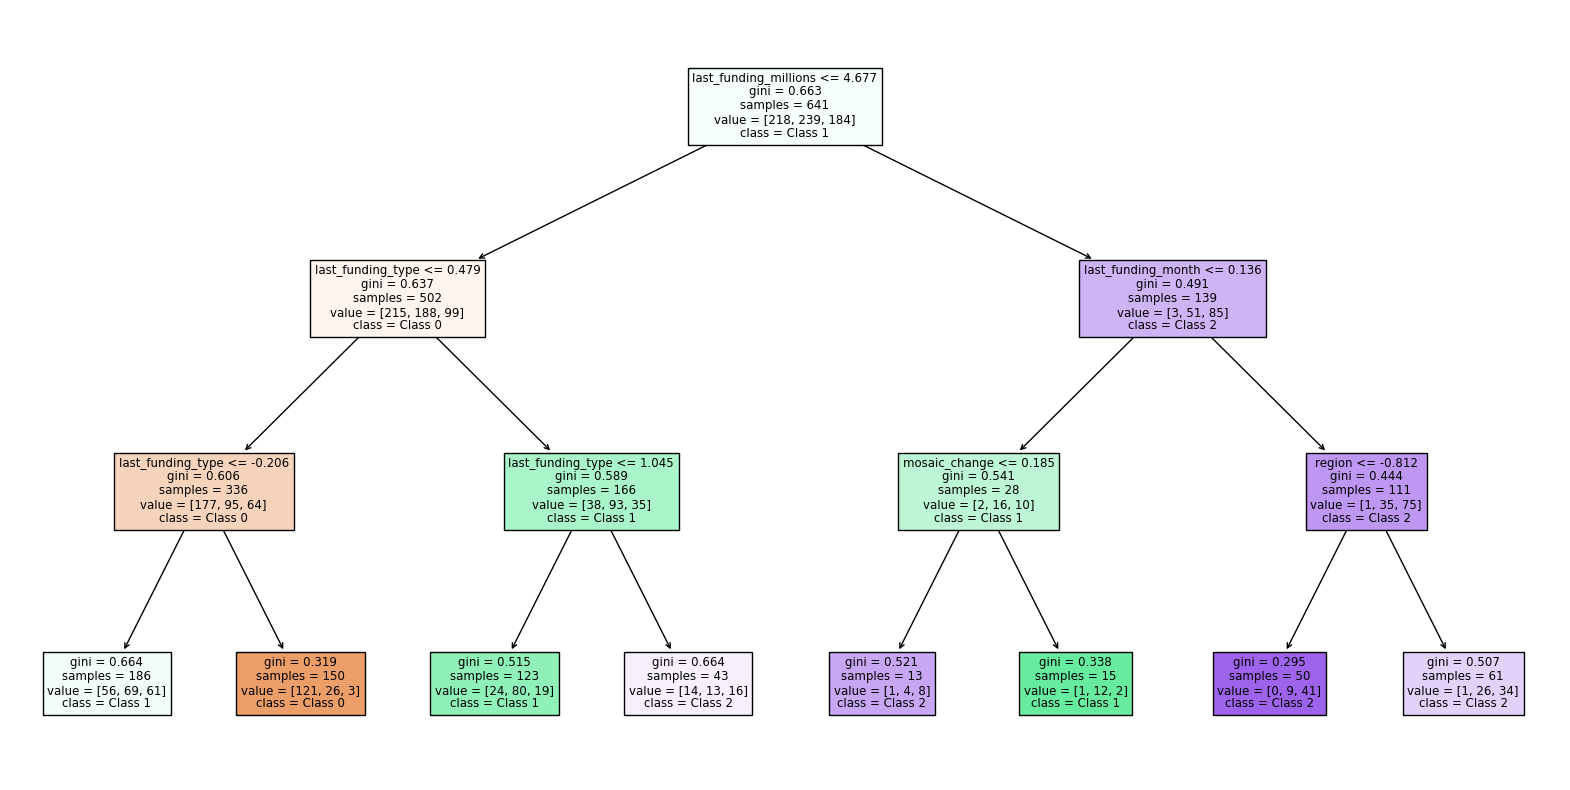

In [140]:
dt_trainer = DecisionTreeTrainer(X_train, y_train, X_test, y_test, params={'max_depth': 3})
dt_trainer.train()
dt_trainer.predict()
dt_trainer.print_summary()

In [106]:
dt_trainer.display_predictions_dataframe(display_type='both', length=10)

Total predictions: 161


,year_founded,city,region,country,postal_code,mosaic_change,last_funding_millions,last_funding_type,last_funding_year,last_funding_month,last_funding_day,keyword_bins_0,keyword_bins_1,keyword_bins_2,keyword_bins_3,keyword_bins_4,keyword_bins_5,True Label,Predicted Label
192,-1.378379,0.373737,-0.615291,0.953488,-0.409936,-0.616438,4.103635,0.673357,0.800000,0.000000,0.833333,0,0,0,0,0,1,0,1
294,1.022547,0.025888,-0.543906,0.976744,-0.409936,2.013699,2.639057,0.342352,1.000000,0.636364,0.633333,0,1,0,0,0,0,0,0
168,0.422316,0.121212,0.322203,0.976744,-0.781926,-1.739726,2.079442,0.023822,0.900000,0.545455,0.633333,0,0,0,1,0,0,0,0
521,0.722432,0.727273,0.637576,0.976744,1.676311,1.150685,3.044522,0.506337,1.000000,0.727273,0.766667,0,0,1,0,0,0,1,1
535,0.422316,0.080808,-1.041788,0.976744,-0.781926,-0.095890,2.639057,-0.380163,0.900000,0.454545,0.966667,0,1,0,0,0,0,2,1
788,0.122200,0.373737,-0.615291,0.953488,-0.409936,0.287671,4.867534,0.900637,0.900000,0.272727,0.066667,0,1,0,0,0,0,1,2
591,-0.478032,0.025888,-1.041788,0.976744,-0.409936,-3.397260,3.433987,0.506337,0.400000,0.454545,0.866667,0,0,0,1,0,0,0,1
323,-1.078263,0.060606,-1.041788,0.976744,0.388236,0.315068,2.639057,1.859125,0.900000,0.454545,0.833333,0,0,0,1,0,0,2,2
218,1.922895,0.025888,1.221351,0.093023,-0.409936,4.301370,1.078410,-0.130535,1.000000,0.363636,0.400000,0,0,0,0,1,0,0,0
405,0.722432,0.000000,1.129145,0.976744,-0.781926,0.698630,2.639057,1.984202,1.000000,0.272727,0.800000,0,0,1,0,0,0,2,2



Summary of predictions per class:


Predicted Label,0,1,2
True Label,,,
0,3,2,0
1,0,1,1
2,0,1,2


### Hyperparameter tuning

In [26]:
dt_param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 50, 100],
    'min_samples_leaf': [1, 5, 10]
}

dt_best_params = dt_trainer.tune_hyperparameters(dt_param_grid, cv=5)

Best parameters found: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


Metric,Score
Accuracy,0.491
Precision,0.490
Recall,0.498
F1 Score,0.492


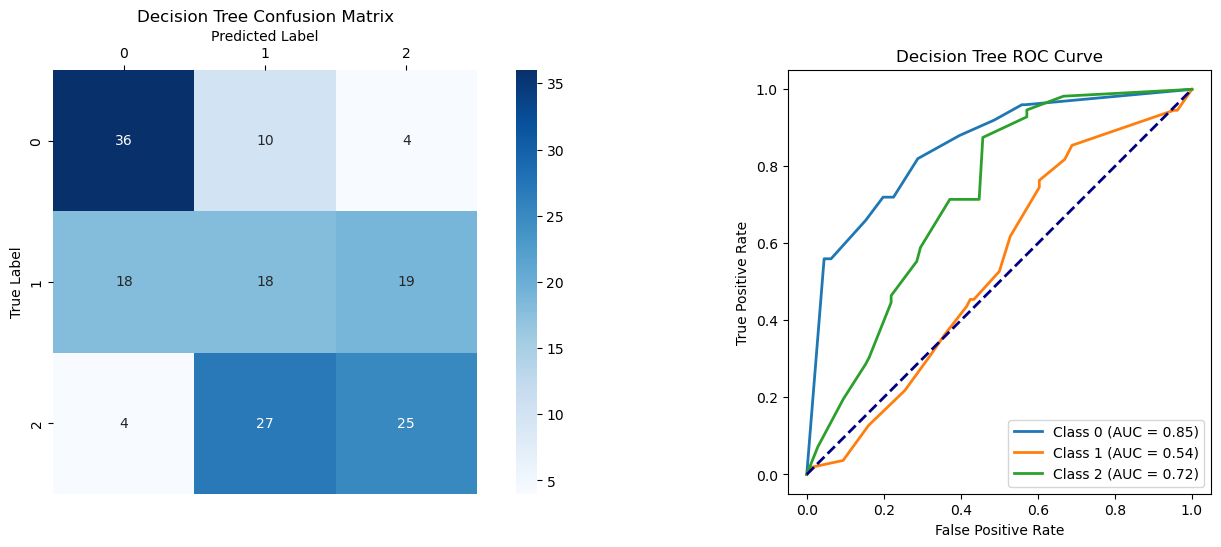

Depth: 5


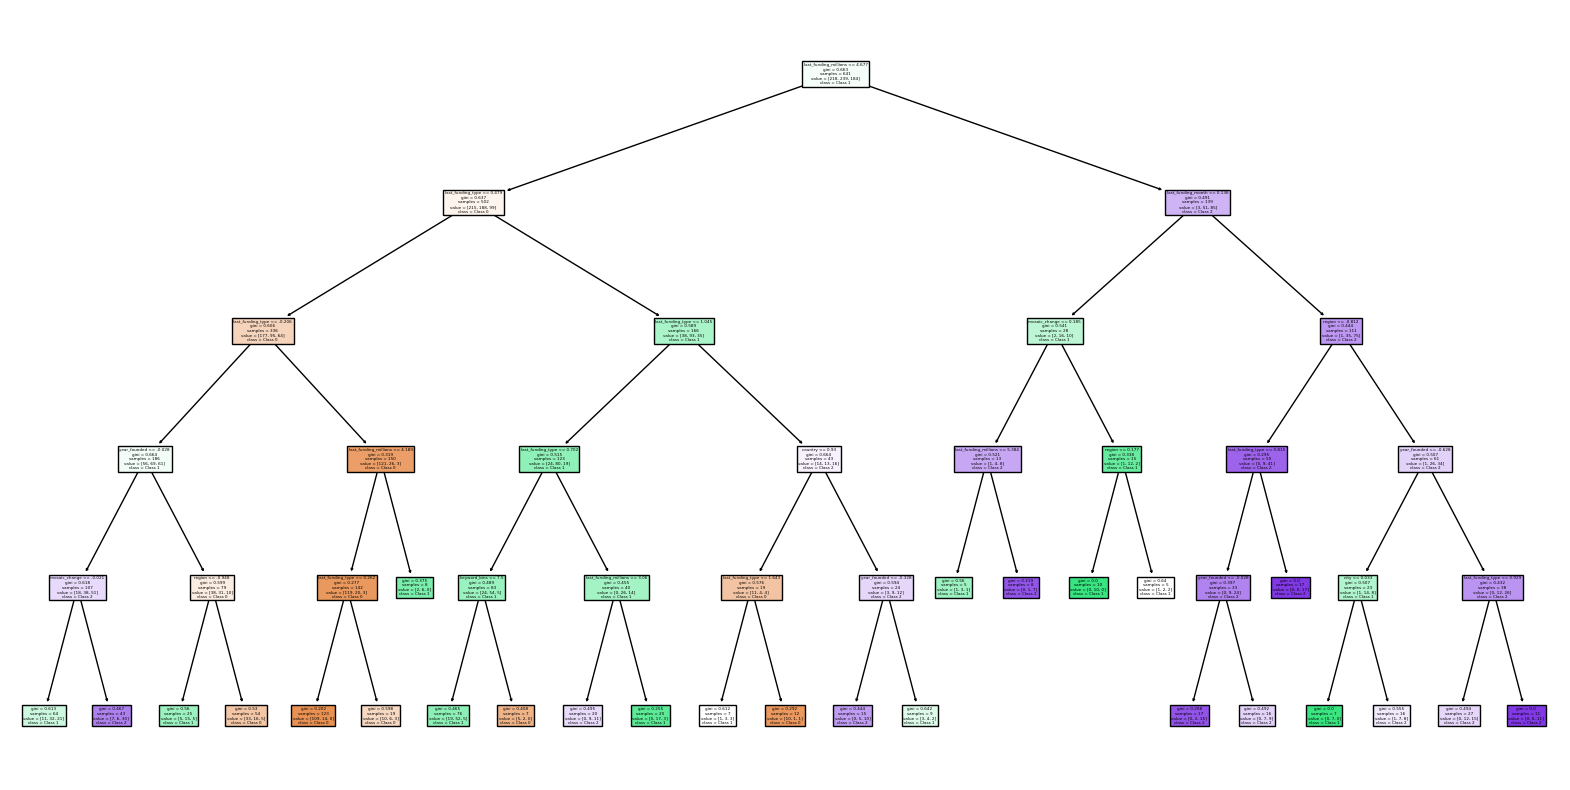

In [27]:
dt_trainer_tuned = DecisionTreeTrainer(X_train, y_train, X_test, y_test, params=dt_best_params)
dt_trainer_tuned.train()
dt_trainer_tuned.predict()
dt_trainer_tuned.print_summary()

## Random Forest

### Model

In [28]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestTrainer(BaseModelTrainer):
    def define_model(self):
        """Defines model as random forest."""
        self.name = 'Random Forest'
        self.model = RandomForestClassifier(**self.params, random_state=1234, verbose=0)
        
    def get_tree_depths(self):
        return [estimator.tree_.max_depth for estimator in rf_trainer.model.estimators_]
    
    def get_average_depth(self, tree_depths):
        return sum(tree_depths) / len(tree_depths)
        
    def print_summary(self):
        super().print_summary()
        tree_depths = self.get_tree_depths()
        print(f'Depths: {tree_depths}')
        print(f'Average depth: {self.get_average_depth(tree_depths)}')

Metric,Score
Accuracy,0.559
Precision,0.552
Recall,0.567
F1 Score,0.554


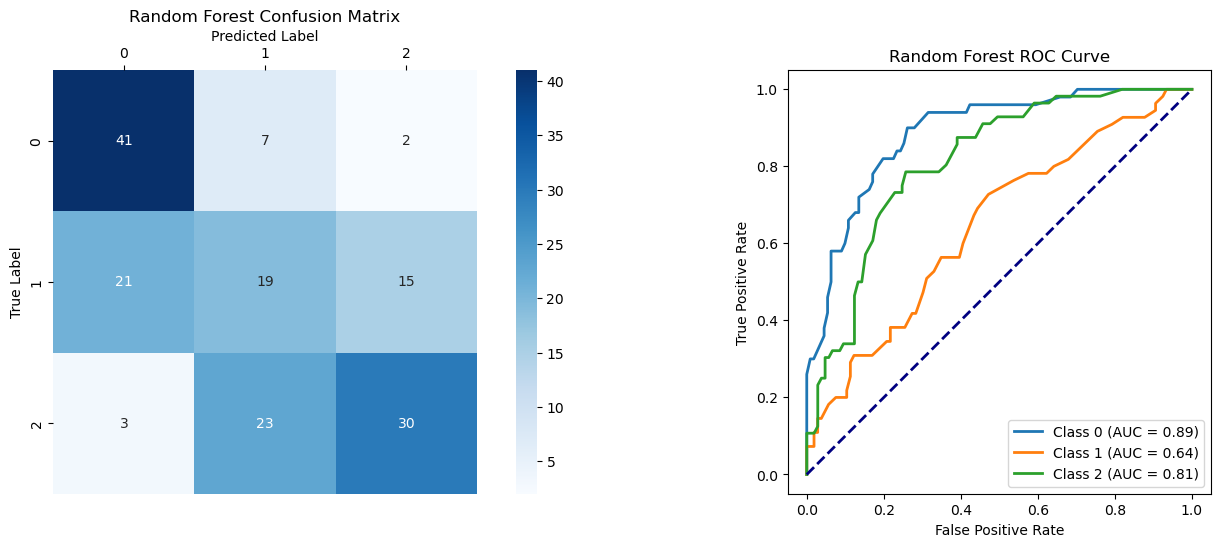

Depths: [16, 15, 18, 17, 15, 16, 16, 18, 18, 18, 14, 15, 15, 16, 18, 14, 17, 16, 15, 14, 14, 16, 18, 17, 17, 18, 16, 17, 15, 24, 19, 15, 17, 18, 16, 15, 19, 21, 21, 14, 18, 16, 18, 14, 15, 16, 17, 14, 15, 15, 17, 15, 15, 21, 17, 19, 15, 14, 24, 17, 16, 15, 13, 18, 17, 15, 15, 17, 18, 15, 18, 15, 17, 16, 18, 14, 16, 19, 17, 14, 18, 16, 17, 16, 15, 19, 15, 17, 15, 16, 17, 18, 16, 17, 15, 17, 15, 17, 15, 23]
Average depth: 16.57


In [141]:
rf_trainer = RandomForestTrainer(X_train, y_train, X_test, y_test, params={'n_estimators': 100})
rf_trainer.train()
rf_trainer.predict()
rf_trainer.print_summary()

### Hyperparameter tuning

In [30]:
rf_param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 15, None]
}

rf_best_params = rf_trainer.tune_hyperparameters(rf_param_grid, cv=3)

Best parameters found: {'max_depth': None, 'n_estimators': 400}


Metric,Score
Accuracy,0.571
Precision,0.563
Recall,0.579
F1 Score,0.566


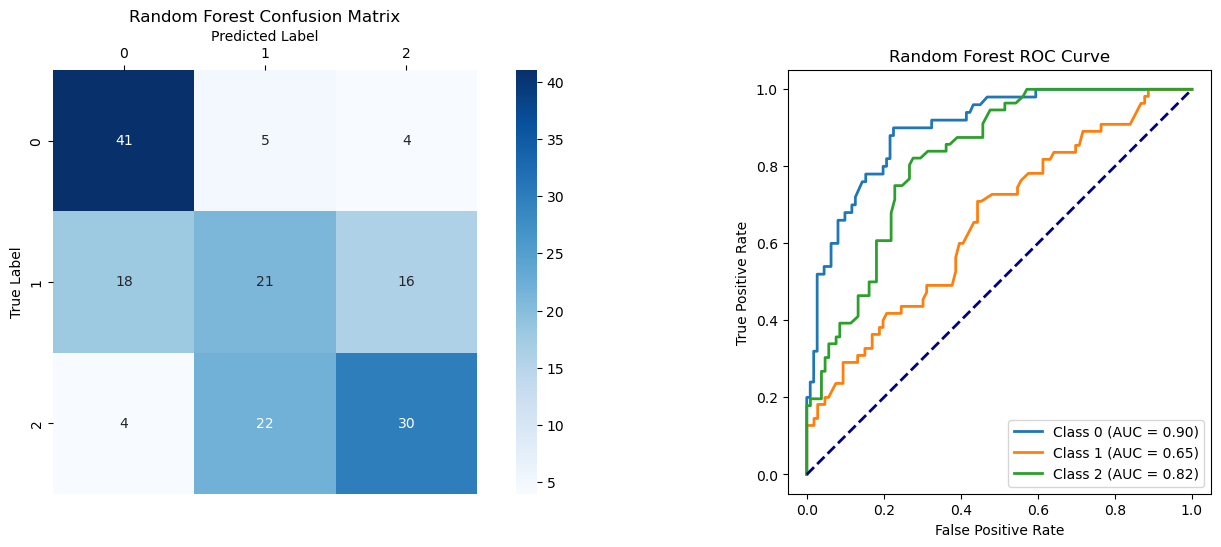

Depths: [15, 14, 15, 16, 16, 14, 14, 16, 15, 14, 17, 14, 18, 16, 15, 17, 15, 16, 15, 15, 18, 14, 14, 14, 14, 16, 15, 15, 16, 16, 13, 15, 14, 18, 18, 15, 17, 16, 14, 14, 17, 18, 15, 18, 17, 15, 18, 14, 14, 14, 17, 17, 16, 15, 18, 15, 14, 17, 14, 18, 15, 16, 17, 19, 15, 15, 14, 15, 20, 15, 18, 17, 16, 17, 13, 14, 14, 15, 18, 14, 16, 16, 14, 15, 16, 15, 17, 18, 13, 16, 16, 16, 15, 16, 17, 15, 14, 15, 13, 17, 15, 18, 13, 15, 17, 13, 17, 13, 13, 16, 17, 16, 17, 16, 16, 14, 20, 19, 18, 15, 14, 14, 17, 14, 15, 18, 15, 14, 15, 16, 14, 15, 16, 14, 14, 16, 14, 16, 17, 17, 17, 15, 15, 13, 13, 15, 15, 15, 14, 15, 16, 17, 14, 15, 17, 18, 16, 16, 15, 14, 14, 16, 14, 15, 16, 15, 14, 15, 15, 15, 18, 13, 19, 14, 15, 16, 14, 16, 17, 16, 18, 15, 16, 13, 15, 13, 19, 17, 15, 19, 16, 14, 13, 15, 15, 16, 20, 14, 17, 14, 15, 17, 17, 14, 18, 17, 15, 15, 14, 15, 16, 18, 13, 15, 16, 18, 16, 16, 15, 15, 15, 15, 15, 20, 16, 17, 15, 14, 19, 17, 15, 19, 15, 18, 13, 15, 20, 15, 15, 16, 18, 20, 16, 15, 16, 15, 15, 15,

In [31]:
rf_trainer_tuned = RandomForestTrainer(X_train, y_train, X_test, y_test, params=rf_best_params)
rf_trainer_tuned.train()
rf_trainer_tuned.predict()
rf_trainer_tuned.print_summary()

## Logistic Regression

### Model

In [153]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionTrainer(BaseModelTrainer):
    def define_model(self):
        """Defines model as logistic regression."""
        self.name = 'Logistic Regression'
        self.model = LogisticRegression(**self.params, max_iter=500, solver='liblinear', random_state=1234)
        
    def plot_parameters(self):
        """Plots intercept and coefficients for each class in multiclass regression."""
        intercepts = self.model.intercept_
        coefficients = self.model.coef_
        feature_names = self.X_train.columns

        num_classes = coefficients.shape[0]

        fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 6), sharey=True)
        if num_classes == 1:
            axes = [axes] 

        for i, (intercept, coef, ax) in enumerate(zip(intercepts, coefficients, axes)):
            print(f'Class {i} Intercept: {intercept}')

            coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
            coef_df.sort_values(by='Coefficient', ascending=False, inplace=True)

            ax.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
            ax.axvline(0, color='black', linewidth=0.8)
            ax.set_title(f'Class {i} Coefficients')
            ax.set_xlabel('Coefficient Value')

        fig.supylabel('Feature', fontsize=14)
        plt.tight_layout()
        plt.show()


        
    def print_summary(self):
        super().print_summary()
        self.plot_parameters()

Metric,Score
Accuracy,0.522
Precision,0.523
Recall,0.530
F1 Score,0.514


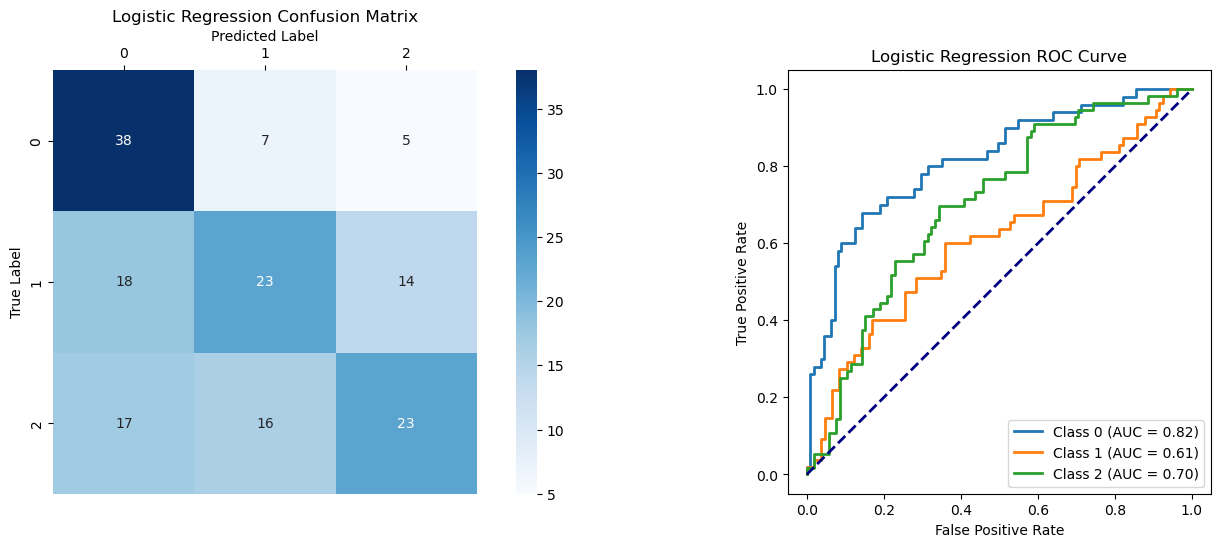

Class 0 Intercept: 2.1256431553987034
Class 1 Intercept: -0.565932341789051
Class 2 Intercept: -2.7879716032714743


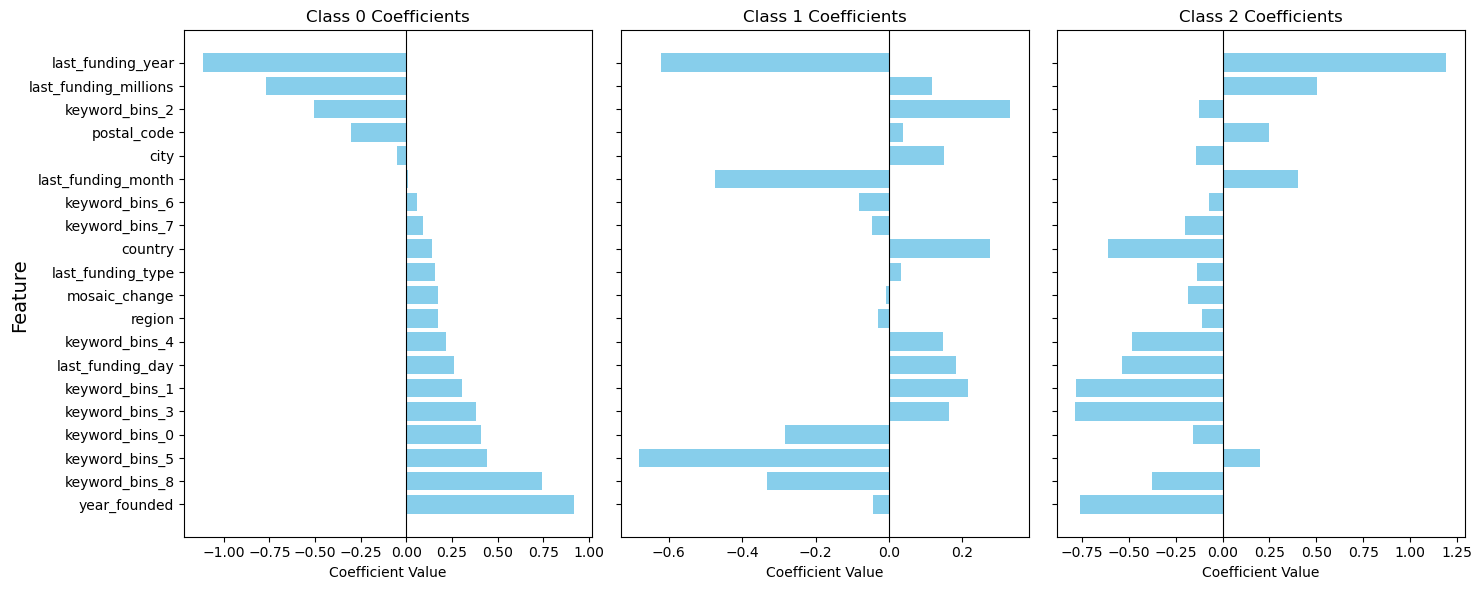

In [142]:
lr_trainer = LogisticRegressionTrainer(X_train, y_train, X_test, y_test)
lr_trainer.train()
lr_trainer.predict()
lr_trainer.print_summary()

### Hyperparameter tuning

In [151]:
import warnings
from sklearn.exceptions import FitFailedWarning

# Suppress warnings when fit fails with certain parameters
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", UserWarning)

lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 100, 500, 1000]
}

lr_best_params = lr_trainer.tune_hyperparameters(lr_param_grid, cv=5)

Best parameters found: {'C': 100, 'penalty': 'l1'}


Metric,Score
Accuracy,0.571
Precision,0.579
Recall,0.578
F1 Score,0.566


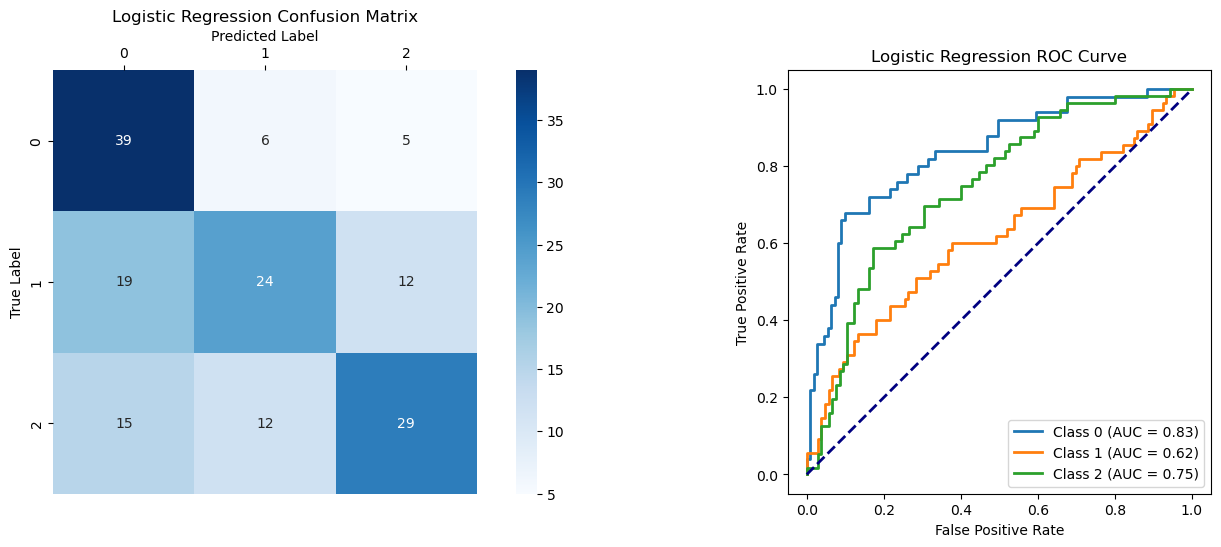

Class 0 Intercept: 5.185509107785031
Class 1 Intercept: -0.4333137637021516
Class 2 Intercept: -6.679878459347155


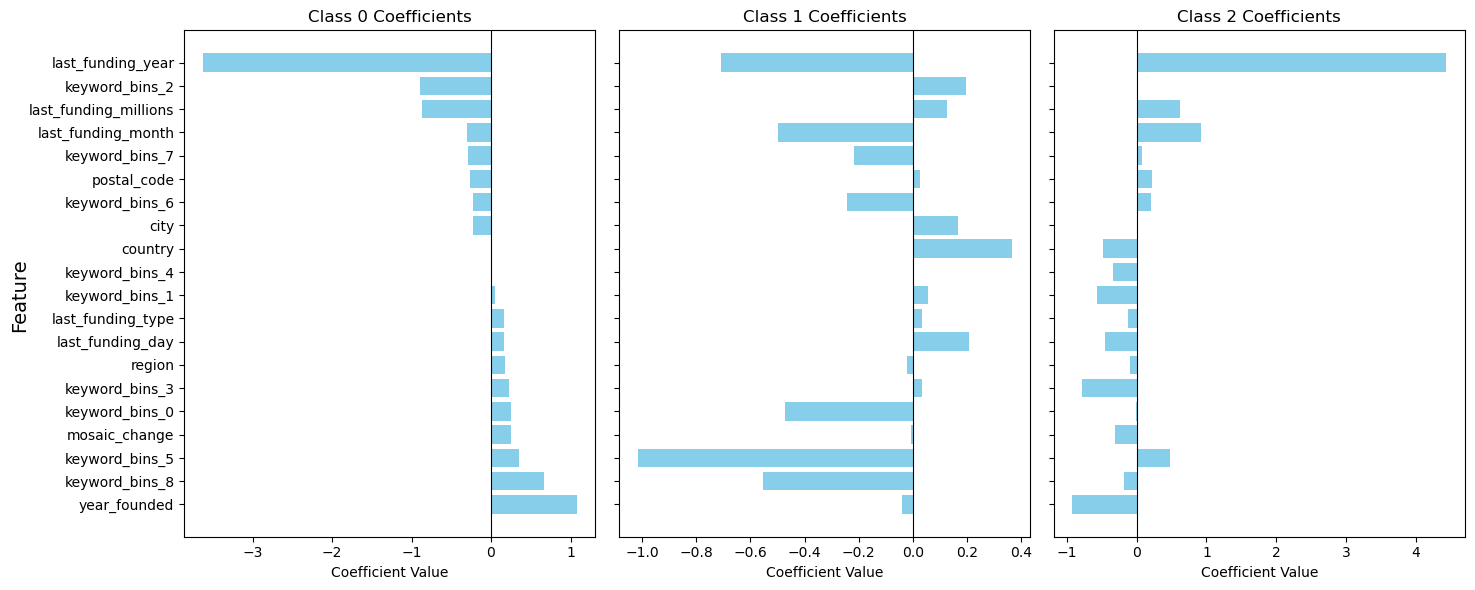

In [154]:
lr_trainer_tuned = LogisticRegressionTrainer(X_train, y_train, X_test, y_test, params=lr_best_params)
lr_trainer_tuned.train()
lr_trainer_tuned.predict()
lr_trainer_tuned.print_summary()

## KNN

### Model

In [36]:
from sklearn.neighbors import KNeighborsClassifier

class KNNTrainer(BaseModelTrainer):
    def define_model(self):
        """Defines model as KNN."""
        self.name = 'K-Nearest Neigbors'
        self.model = KNeighborsClassifier(**self.params)
        
    def get_neighbors(self):
        return self.model.n_neighbors
        
    def print_summary(self):
        super().print_summary()
        print(f'Number of neighbors: {self.get_neighbors()}')

Metric,Score
Accuracy,0.528
Precision,0.541
Recall,0.534
F1 Score,0.526


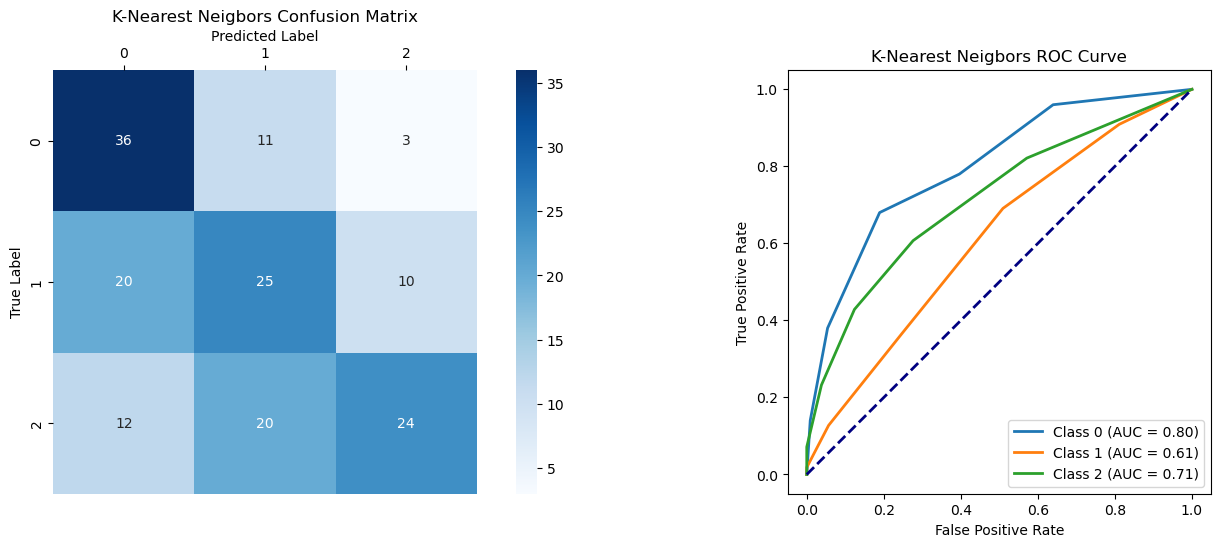

Number of neighbors: 5


In [155]:
knn_trainer = KNNTrainer(X_train, y_train, X_test, y_test, params={'n_neighbors': 5})
knn_trainer.train()
knn_trainer.predict()
knn_trainer.print_summary()

### Hyperparameter tuning

In [156]:
knn_param_grid = {
    'n_neighbors': [3, 5, 10, 15],
    'weights': ['uniform', 'distance']
}

knn_best_params = knn_trainer.tune_hyperparameters(knn_param_grid, cv=5)

Best parameters found: {'n_neighbors': 15, 'weights': 'distance'}


Metric,Score
Accuracy,0.553
Precision,0.563
Recall,0.560
F1 Score,0.549


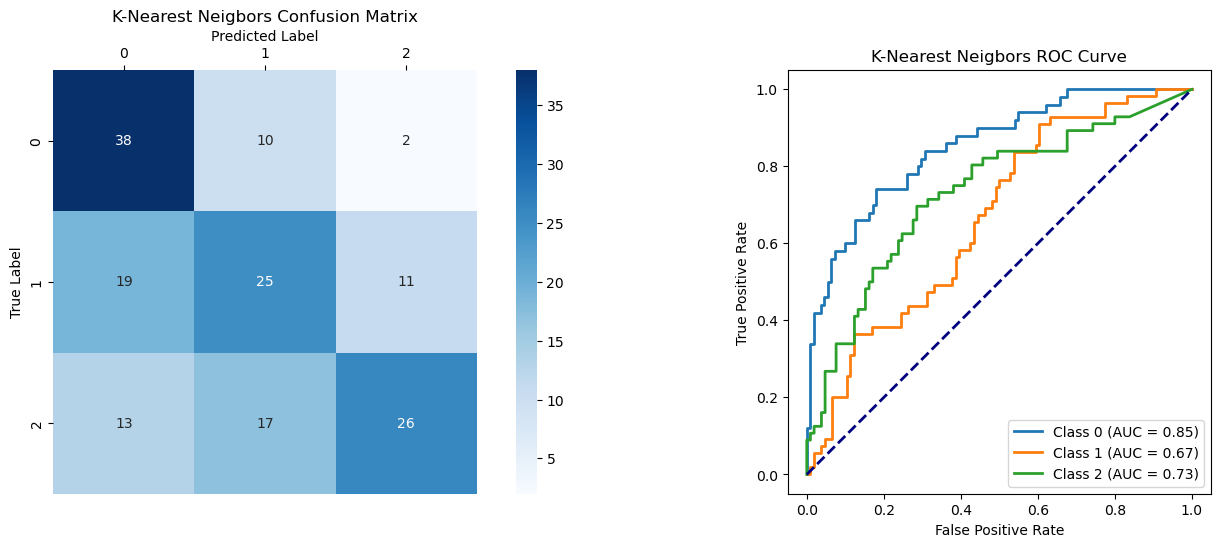

Number of neighbors: 15


In [157]:
knn_trainer_tuned = KNNTrainer(X_train, y_train, X_test, y_test, params=knn_best_params)
knn_trainer_tuned.train()
knn_trainer_tuned.predict()
knn_trainer_tuned.print_summary()

## SVM

### Model

In [38]:
from sklearn.svm import SVC

class SVMTrainer(BaseModelTrainer):
    def define_model(self):
        """Defines model as SVM (specifically SVC)."""
        self.name = 'Support Vector Machine'
        self.model = SVC(**self.params, probability=True, random_state=1234, verbose=False)
        
    def get_kernel(self):
        return self.model.kernel
    
    def get_support_vectors(self):
        return self.model.support_
        
    def print_summary(self):
        super().print_summary()
        print(f'Kernel: {self.get_kernel()}')
        print(f'Number of support vectors: {len(self.get_support_vectors())}')

Metric,Score
Accuracy,0.528
Precision,0.537
Recall,0.536
F1 Score,0.523


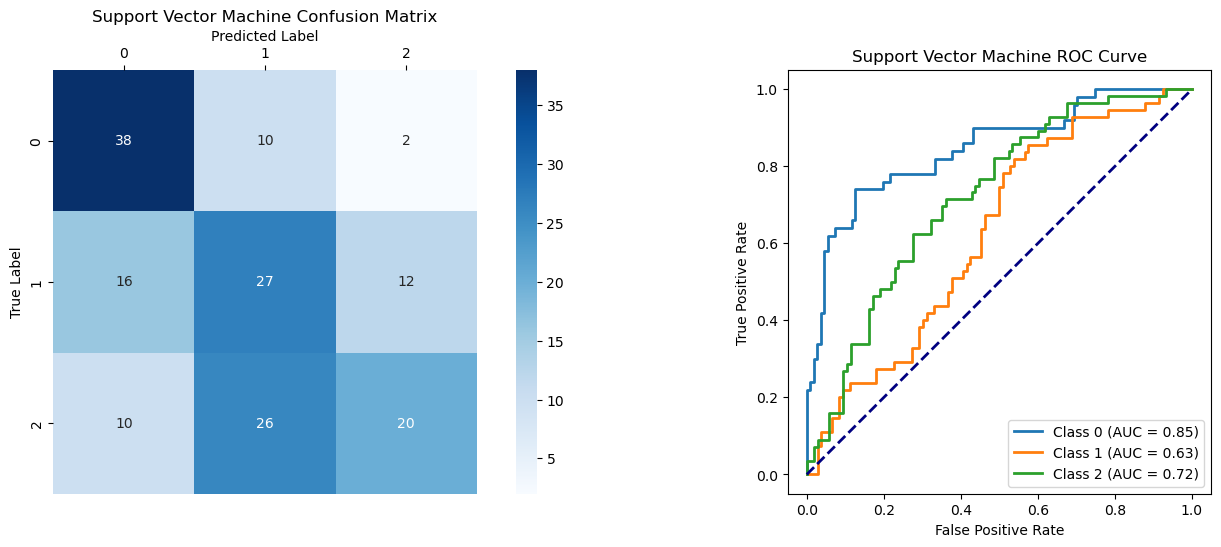

Kernel: rbf
Number of support vectors: 573


In [158]:
svm_trainer = SVMTrainer(X_train, y_train, X_test, y_test)
svm_trainer.train()
svm_trainer.predict()
svm_trainer.print_summary()

### Hyperparameter tuning

In [159]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

svm_best_params = svm_trainer.tune_hyperparameters(svm_param_grid, cv=3)

Best parameters found: {'C': 1, 'kernel': 'rbf'}


Metric,Score
Accuracy,0.528
Precision,0.537
Recall,0.536
F1 Score,0.523


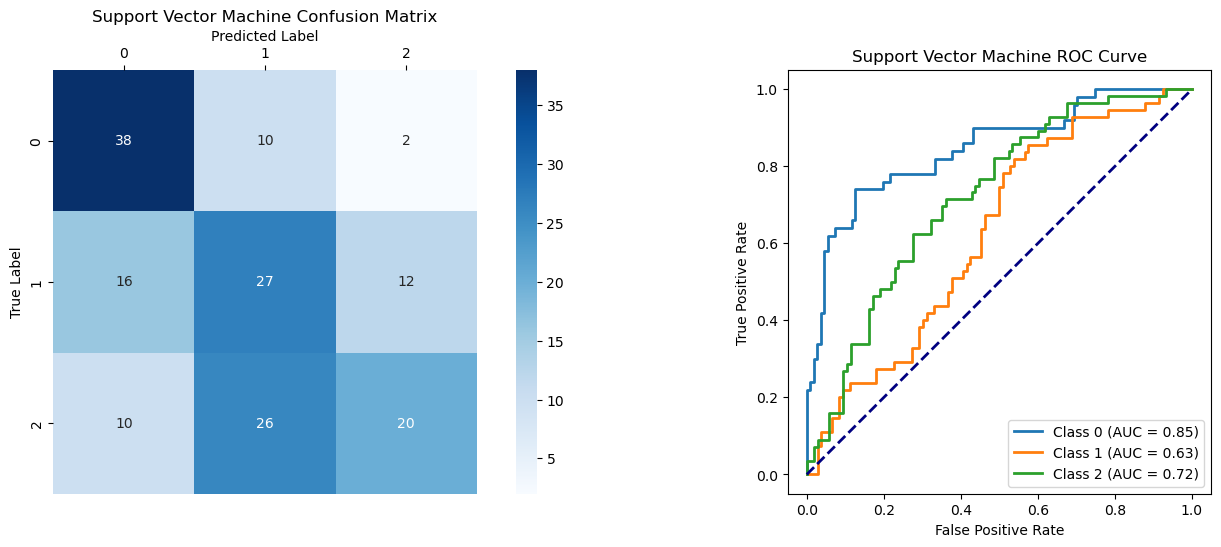

Kernel: rbf
Number of support vectors: 573


In [160]:
svm_trainer_tuned = SVMTrainer(X_train, y_train, X_test, y_test, params=svm_best_params)
svm_trainer_tuned.train()
svm_trainer_tuned.predict()
svm_trainer_tuned.print_summary()

## Naive Bayes

### Model

In [161]:
from sklearn.naive_bayes import GaussianNB

class NaiveBayesTrainer(BaseModelTrainer):
    def define_model(self):
        """Defines model as Naive Bayes (specifically GaussianNB)."""
        self.name = 'Naive Bayes'
        self.model = GaussianNB(**self.params)
        
    def print_summary(self):
        """Prints the model summary."""
        super().print_summary()

Metric,Score
Accuracy,0.509
Precision,0.511
Recall,0.517
F1 Score,0.502


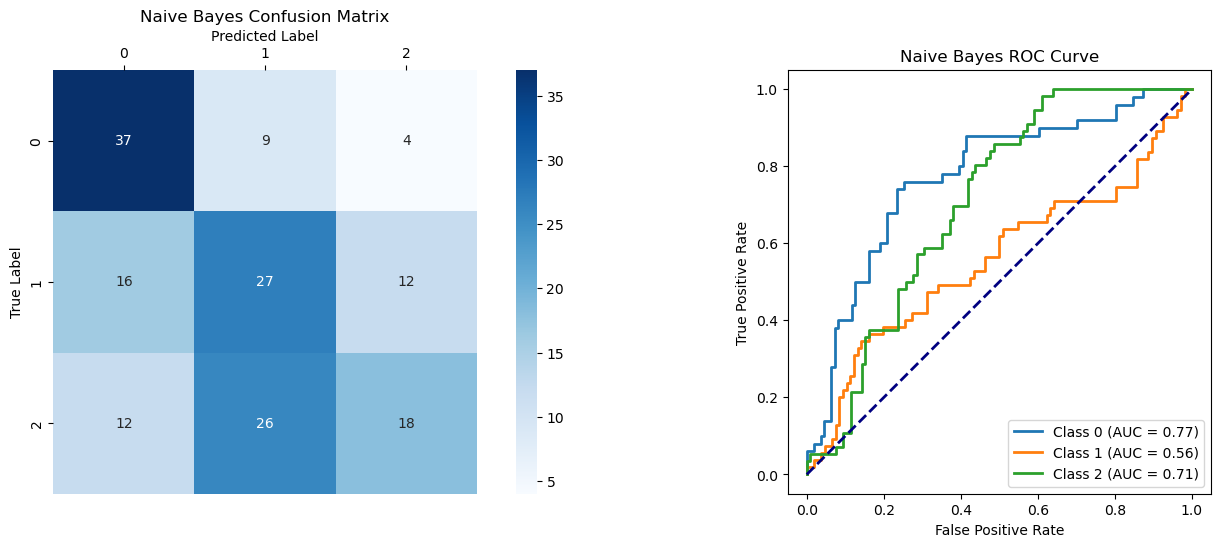

In [162]:
nb_trainer = NaiveBayesTrainer(X_train, y_train, X_test, y_test)
nb_trainer.train()
nb_trainer.predict()
nb_trainer.print_summary()

### Hyperparameter tuning

In [104]:
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

nb_best_params = nb_trainer.tune_hyperparameters(nb_param_grid, cv=5)

Best parameters found: {'var_smoothing': 1e-09}


Metric,Score
Accuracy,0.528
Precision,0.527
Recall,0.533
F1 Score,0.528


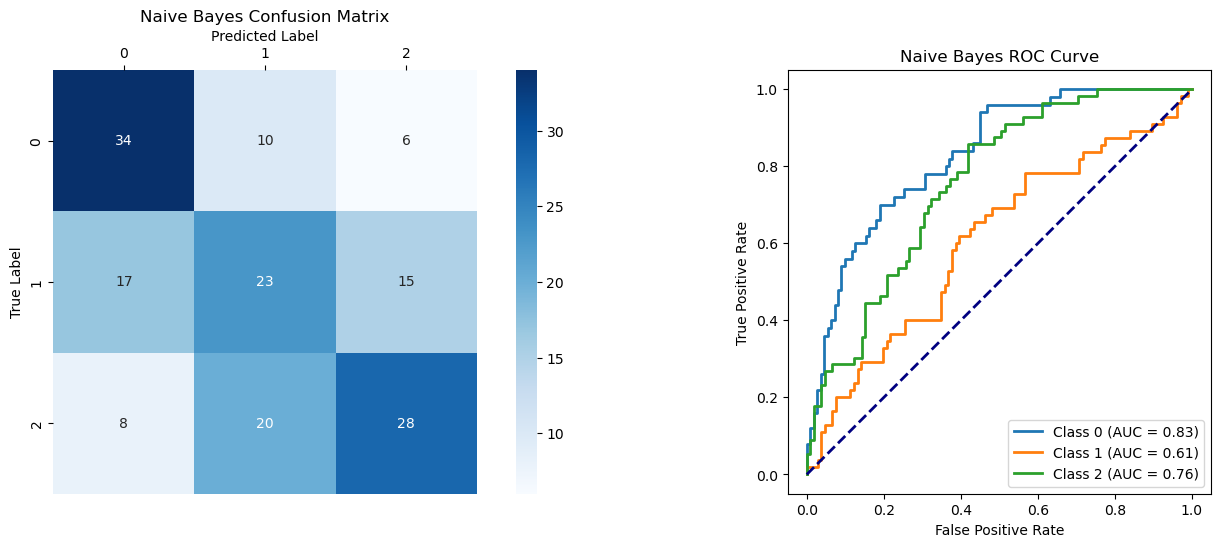

In [126]:
nb_trainer_tuned = NaiveBayesTrainer(X_train, y_train, X_test, y_test, params=nb_best_params)
nb_trainer_tuned.train()
nb_trainer_tuned.predict()
nb_trainer_tuned.print_summary()